1.0.2 - Add in Weights and biases integration.


In [1]:
# Setup notebook

# set up weights and biases
import wandb
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
wandb_api = user_secrets.get_secret("wandb") 
wandb.login(key=wandb_api)

wandb.init(
    project="kaggle-store-sales",
    
    # track hyperparameters and run metadata
#     config={
#     }
)

from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: ant358. Use `wandb login --relogin` to force relogin


In [2]:
plot_params = {'color': '0.75', 'style': '.-', 'markeredgecolor': '0.25', 'markerfacecolor': '0.25', 'legend': False}

In [3]:
def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax


def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette(
        "husl",
        n_colors=X[period].nunique(),
    )
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax

In [4]:
# set path to the data
comp_dir = Path('../input/store-sales-time-series-forecasting')

holidays_events = pd.read_csv(
    comp_dir / "holidays_events.csv",
    # set data types
    dtype={
        'type': 'category',
        'locale': 'category',
        'locale_name': 'category',
        'description': 'category',
        'transferred': 'bool',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
# group by daily period
holidays_events = holidays_events.set_index('date').to_period('D')

# import train csv
store_sales = pd.read_csv(
    comp_dir / 'train.csv',
    
    # drop the onpromotion column
    usecols=['store_nbr', 'family', 'date', 'sales'],
    # set the data types
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
# group  by day
store_sales['date'] = store_sales.date.dt.to_period('D')
# sort in date order
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()

In [5]:
holidays_events.head()

,type,locale,locale_name,description,transferred
date,,,,,
2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [6]:
store_sales.head()

sales
store_nbr family     date             
1         AUTOMOTIVE 2013-01-01    0.0
                     2013-01-02    2.0
                     2013-01-03    3.0
                     2013-01-04    3.0
                     2013-01-05    5.0

## Is there any seasonality?

In [7]:
# create a series of average sales
average_sales = (
    store_sales
    .groupby('date').mean()
    .squeeze()
    # limit to 2017
    .loc['2017']
)

In [8]:
average_sales

date
2017-01-01      6.780303
2017-01-02    786.928406
2017-01-03    619.740234
2017-01-04    555.608032
2017-01-05    436.375397
                 ...    
2017-08-11    463.733856
2017-08-12    444.798279
2017-08-13    485.768616
2017-08-14    427.004730
2017-08-15    427.980896
Freq: D, Name: sales, Length: 227, dtype: float32

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:50: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.



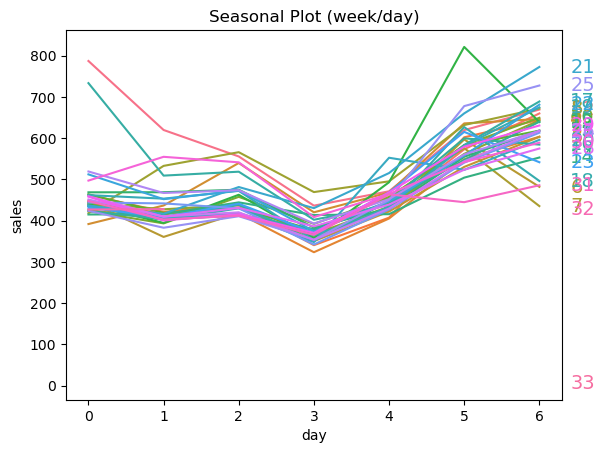

In [9]:
# plot the average sales
X = average_sales.to_frame()
X["week"] = X.index.week
X["day"] = X.index.dayofweek
seasonal_plot(X, y='sales', period='week', freq='day');

And also the periodogram:

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version
  """Entry point for launching an IPython kernel.


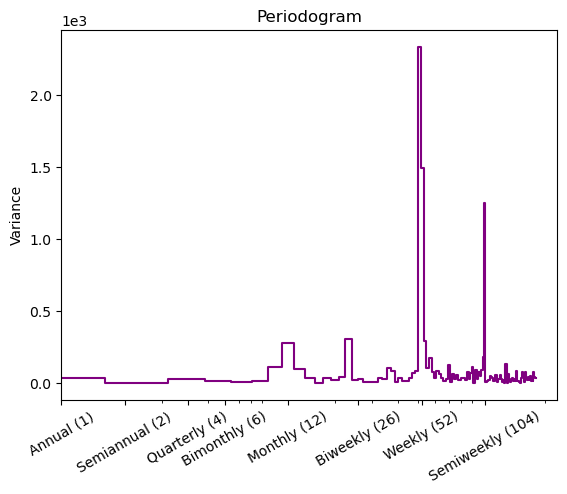

In [10]:
plot_periodogram(average_sales);

### Seasonality conclusion

Seasonality exists at the monthly and lower time frames.   
There is a daily sales pattern

## Plot the monthly seasonal variation

In [11]:
X.head()

,sales,week,day
date,,,
2017-01-01,6.780303,52,6
2017-01-02,786.928406,1,0
2017-01-03,619.740234,1,1
2017-01-04,555.608032,1,2
2017-01-05,436.375397,1,3


In [12]:
# add a month column
X["month"] = X.index.month

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:50: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.



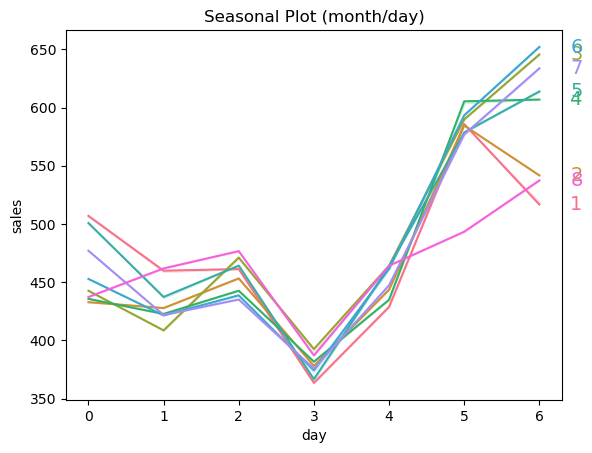

In [13]:
# plot the monthly daily variation
seasonal_plot(X, y='sales', period='month', freq='day');

-------------------------------------------------------------------------------

## Create seasonal features

Use `DeterministicProcess` and `CalendarFourier` to create:
- indicators for weekly seasons and
- Fourier features of order 4 for monthly seasons.

In [14]:
y = average_sales.copy()

# add a fourier feature for monthly cycles
fourier = CalendarFourier(freq="M", order=4)

# add daily features
dp = DeterministicProcess(
    index=y.index,
    constant=True,
    order=1,
    seasonal=True,
    additional_terms=[fourier],
    drop=True,
)

X = dp.in_sample()


In [15]:
# check the result
X.head()

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=M)","cos(1,freq=M)","sin(2,freq=M)","cos(2,freq=M)","sin(3,freq=M)","cos(3,freq=M)","sin(4,freq=M)","cos(4,freq=M)"
date,,,,,,,,,,,,,,,,
2017-01-01,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
2017-01-02,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.201299,0.979530,0.394356,0.918958,0.571268,0.820763,0.724793,0.688967
2017-01-03,1.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.394356,0.918958,0.724793,0.688967,0.937752,0.347305,0.998717,-0.050649
2017-01-04,1.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.571268,0.820763,0.937752,0.347305,0.968077,-0.250653,0.651372,-0.758758
2017-01-05,1.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,0.724793,0.688967,0.998717,-0.050649,0.651372,-0.758758,-0.101168,-0.994869


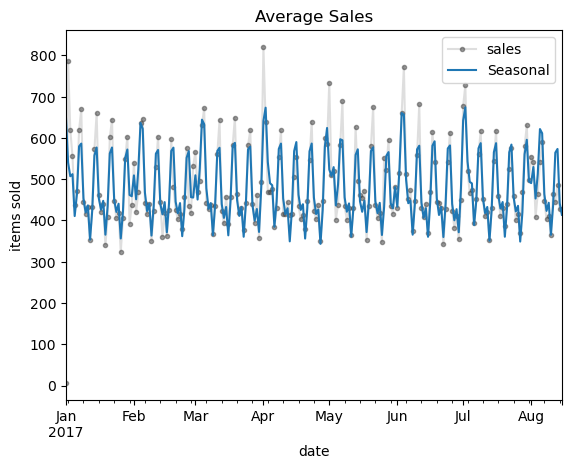

In [16]:
# fit the seasonal model
model = LinearRegression().fit(X, y)
y_pred = pd.Series(
    model.predict(X),
    index=X.index,
    name='Fitted',
)

# inspect the fit
y_pred = pd.Series(model.predict(X), index=X.index)
ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, label="Seasonal")
ax.legend();

-------------------------------------------------------------------------------


## Deseasonalising the data.

Check with the periodogram of the deseasonalized series.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version
  import sys


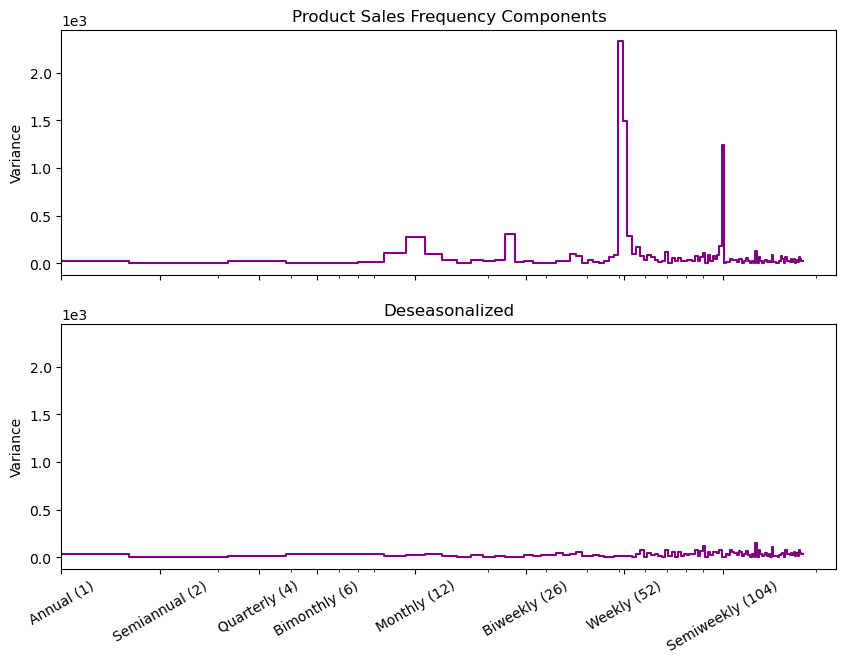

In [17]:
# subtract the seasonal predictions from the original data
y_deseason = y - y_pred

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))
ax1 = plot_periodogram(y, ax=ax1)
ax1.set_title("Product Sales Frequency Components")
ax2 = plot_periodogram(y_deseason, ax=ax2);
ax2.set_title("Deseasonalized");

## Add the holiday events to the training data

In [18]:
# National and regional holidays in the training set
holidays = (
    holidays_events
    .query("locale in ['National', 'Regional']")
    .loc['2017':'2017-08-15', ['description']]
    .assign(description=lambda x: x.description.cat.remove_unused_categories())
)

display(holidays)

,description
date,
2017-01-01,Primer dia del ano
2017-01-02,Traslado Primer dia del ano
2017-02-27,Carnaval
2017-02-28,Carnaval
2017-04-01,Provincializacion de Cotopaxi
2017-04-14,Viernes Santo
2017-05-01,Dia del Trabajo
2017-05-13,Dia de la Madre-1
2017-05-14,Dia de la Madre


Plot the deseasonalized *Average Sales*, do these holidays have some predictive power?

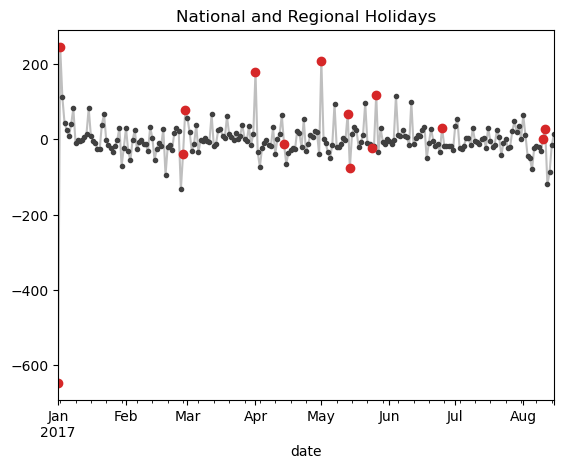

In [19]:
ax = y_deseason.plot(**plot_params)
plt.plot_date(holidays.index, y_deseason[holidays.index], color='C3')
ax.set_title('National and Regional Holidays');

Yes they do!

## Create holiday features

Different holidays had different effects. Create a feature for each holiday name


In [20]:
pd.get_dummies(holidays)

,description_Batalla de Pichincha,description_Carnaval,description_Dia de la Madre,description_Dia de la Madre-1,description_Dia del Trabajo,description_Primer Grito de Independencia,description_Primer dia del ano,description_Provincializacion de Cotopaxi,description_Provincializacion de Imbabura,description_Traslado Batalla de Pichincha,description_Traslado Primer Grito de Independencia,description_Traslado Primer dia del ano,description_Viernes Santo
date,,,,,,,,,,,,,
2017-01-01,0,0,0,0,0,0,1,0,0,0,0,0,0
2017-01-02,0,0,0,0,0,0,0,0,0,0,0,1,0
2017-02-27,0,1,0,0,0,0,0,0,0,0,0,0,0
2017-02-28,0,1,0,0,0,0,0,0,0,0,0,0,0
2017-04-01,0,0,0,0,0,0,0,1,0,0,0,0,0
2017-04-14,0,0,0,0,0,0,0,0,0,0,0,0,1
2017-05-01,0,0,0,0,1,0,0,0,0,0,0,0,0
2017-05-13,0,0,0,1,0,0,0,0,0,0,0,0,0
2017-05-14,0,0,1,0,0,0,0,0,0,0,0,0,0


In [21]:
# Add the dummies to X to create X_2
X_holidays = pd.get_dummies(holidays)

X2 = X.join(X_holidays, on='date').fillna(0.0)


## Fit the seasonal model with holiday features added. 

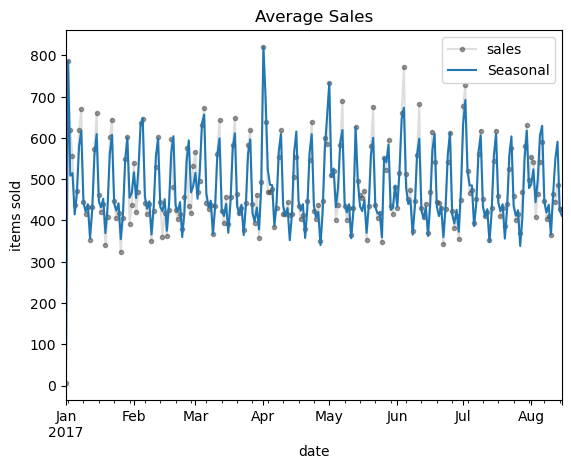

In [22]:
# fit X_2
model = LinearRegression().fit(X2, y)
y_pred = pd.Series(
    model.predict(X2),
    index=X2.index,
    name='Fitted',
)

y_pred = pd.Series(model.predict(X2), index=X2.index)
ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, label="Seasonal")
ax.legend();

-------------------------------------------------------------------------------

## Create submition to Store Sales competition

First create a seasonal model for the full *Store Sales* dataset with all 1800 time series.

In [23]:
#  why only 2017
y = store_sales.unstack(['store_nbr', 'family']).loc["2017"]

# Create training data
fourier = CalendarFourier(freq='M', order=4)
dp = DeterministicProcess(
    index=y.index,
    constant=True,
    order=1,
    seasonal=True,
    additional_terms=[fourier],
    drop=True,
)
X = dp.in_sample()

# Add a new year feature
X['NewYear'] = (X.index.dayofyear == 1)

model = LinearRegression(fit_intercept=False)
model.fit(X, y)
y_pred = pd.DataFrame(model.predict(X), index=X.index, columns=y.columns)

Check some of its predictions.


CategoricalIndex(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
                  'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI',
                  'EGGS', 'FROZEN FOODS', 'GROCERY I', 'GROCERY II',
                  'HARDWARE', 'HOME AND KITCHEN I', 'HOME AND KITCHEN II',
                  'HOME APPLIANCES', 'HOME CARE', 'LADIESWEAR',
                  'LAWN AND GARDEN', 'LINGERIE', 'LIQUOR,WINE,BEER',
                  'MAGAZINES', 'MEATS', 'PERSONAL CARE', 'PET SUPPLIES',
                  'PLAYERS AND ELECTRONICS', 'POULTRY', 'PREPARED FOODS',
                  'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES', 'SEAFOOD'],
                 categories=['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS', 'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', ...], ordered=False, dtype='category', name='family')

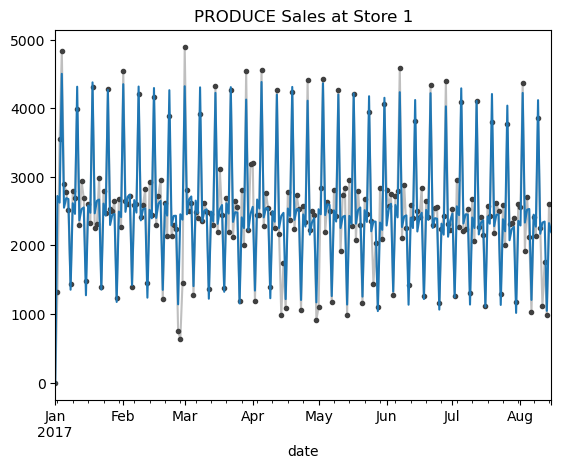

In [24]:
STORE_NBR = '1'  # 1 - 54
FAMILY = 'PRODUCE'
# Uncomment to see a list of product families
display(store_sales.index.get_level_values('family').unique())

ax = y.loc(axis=1)['sales', STORE_NBR, FAMILY].plot(**plot_params)
ax = y_pred.loc(axis=1)['sales', STORE_NBR, FAMILY].plot(ax=ax)
ax.set_title(f'{FAMILY} Sales at Store {STORE_NBR}');

Load the test data, create a feature set for the forecast period, and then creates the submission file `submission.csv`.

In [25]:
df_test = pd.read_csv(
    comp_dir / 'test.csv',
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
df_test['date'] = df_test.date.dt.to_period('D')
df_test = df_test.set_index(['store_nbr', 'family', 'date']).sort_index()

# Create features for test set
X_test = dp.out_of_sample(steps=16)
X_test.index.name = 'date'
X_test['NewYear'] = (X_test.index.dayofyear == 1)


y_submit = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)
y_submit = y_submit.stack(['store_nbr', 'family'])
y_submit = y_submit.join(df_test.id).reindex(columns=['id', 'sales'])
y_submit.to_csv('submission.csv', index=False)